***# Importing required libraries***

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import os
import warnings
import requests

***# Suppress FutureWarnings***

In [24]:
warnings.simplefilter(action='ignore', category=FutureWarning)


***# Download dataset***

In [25]:
dataset_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
dataset_path = "Telco-Customer-Churn.csv"

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    response = requests.get(dataset_url)
    if response.status_code == 200:
        with open(dataset_path, 'wb') as file:
            file.write(response.content)
        print("Dataset downloaded successfully.")
    else:
        raise Exception(f"Failed to download dataset. HTTP Status Code: {response.status_code}")

Dataset downloaded successfully.


***# Load the dataset***

In [26]:
data = pd.read_csv(dataset_path)

***# Display basic info about the dataset***

In [27]:
print("Data Head:\n", data.head())
print("\nData Info:\n")
data.info()

Data Head:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        C

***# Check for missing values***

In [28]:
print("\nMissing Values:\n", data.isnull().sum())
data.drop(['customerID'], axis=1, inplace=True)


Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


***# Handle missing values in TotalCharges***

In [29]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].mean(), inplace=True)


***# Encoding categorical variables and correlation heatmap after encoding***

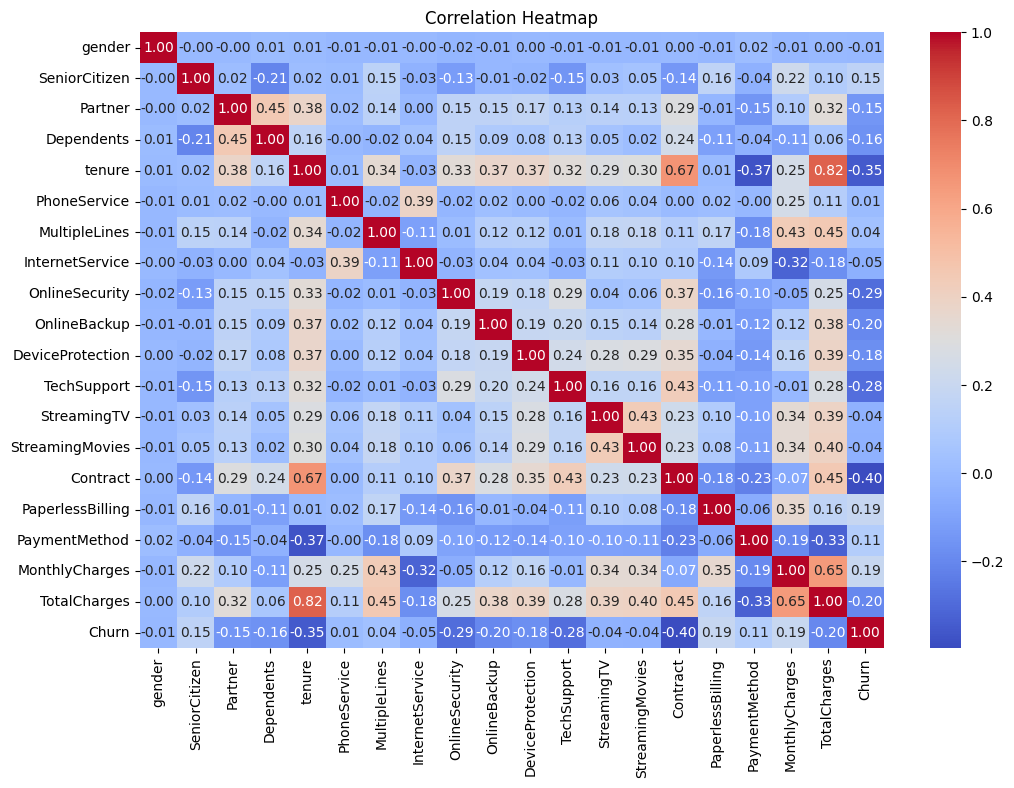

In [30]:
label_enc = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_enc.fit_transform(data[column])

# Correlation heatmap (after encoding categorical variables)
plt.figure(figsize=(12, 8))
try:
    sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
except ValueError as e:
    print(f"Error creating heatmap: {e}")

***# Exploratory Data Analysis (EDA)***

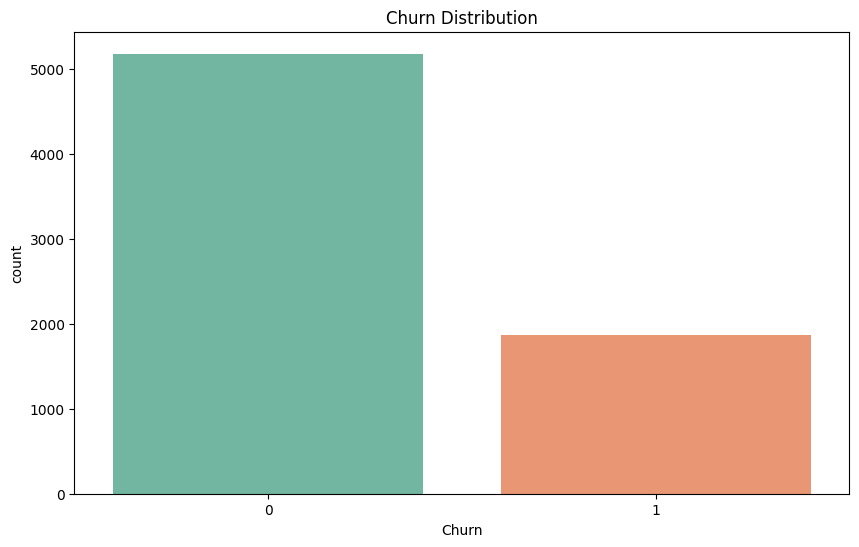

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=data, palette='Set2')
plt.title('Churn Distribution')
plt.show()

***# Splitting the dataset into features and target variable***

In [32]:
X = data.drop('Churn', axis=1)
y = data['Churn']


***# Splitting into training and testing sets***

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

***# Standardizing the features***

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

***# Model comparison and hyperparameter tuning***

In [35]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

best_model = None
best_score = 0

for model_name, model in models.items():
    try:
        print(f"Training {model_name}...")
        param_grid = {
            'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
            'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]},
            'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]},
            'CatBoost': {'iterations': [100, 200], 'learning_rate': [0.1, 0.05]},
            'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]}
        }
        grid = GridSearchCV(model, param_grid[model_name], cv=3, scoring='roc_auc')
        grid.fit(X_train, y_train)
        print(f"Best parameters for {model_name}: {grid.best_params_}")
        print(f"Best ROC AUC score for {model_name}: {grid.best_score_}")

        if grid.best_score_ > best_score:
            best_score = grid.best_score_
            best_model = grid.best_estimator_
    except Exception as e:
        print(f"Error training {model_name}: {e}")

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Best ROC AUC score for Random Forest: 0.8380463725185505
Training Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'n_estimators': 100}
Best ROC AUC score for Gradient Boosting: 0.8428160081547258
Training XGBoost...


C:\Users\Akshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Akshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Akshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } 

Best parameters for XGBoost: {'learning_rate': 0.05, 'n_estimators': 100}
Best ROC AUC score for XGBoost: 0.8373664137679991
Training CatBoost...
Best parameters for CatBoost: {'iterations': 100, 'learning_rate': 0.05}
Best ROC AUC score for CatBoost: 0.8440704451931631
Training LightGBM...
[LightGBM] [Info] Number of positive: 998, number of negative: 2758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265708 -> initscore=-1.016508
[LightGBM] [Info] Start training from score -1.016508
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the

***# Evaluate the best model***


Evaluating the Best Model...
Accuracy Score: 0.8133427963094393
ROC AUC Score: 0.8633341786827042

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.53      0.60       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



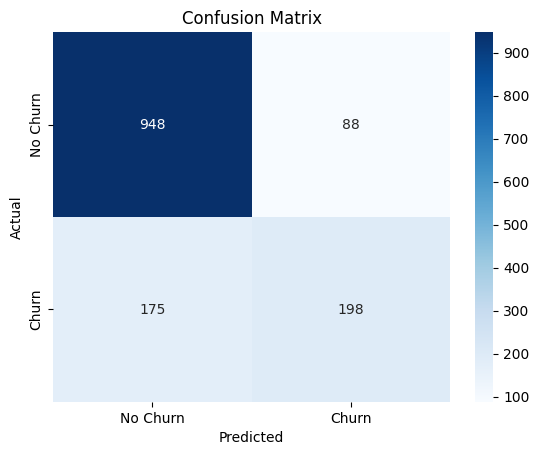

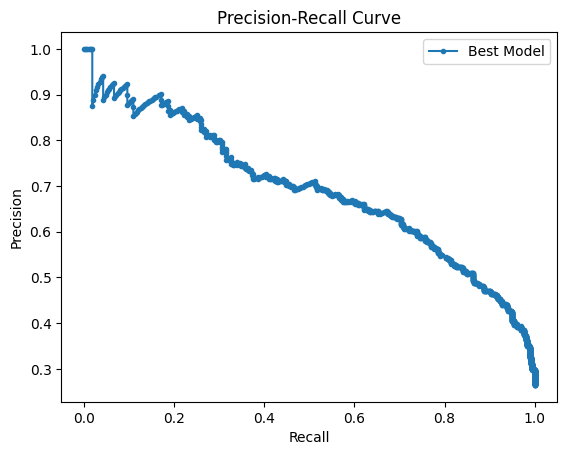

 96%|=================== | 1357/1409 [00:12<00:00]       

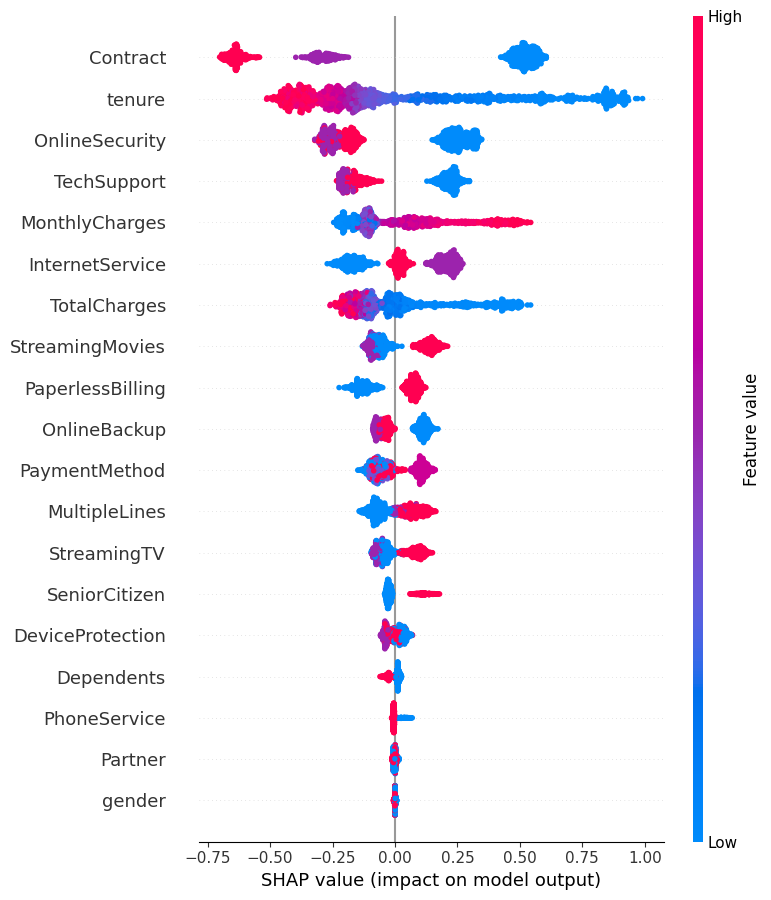


Deployment Suggestion: Host this model using Flask or Streamlit and serve predictions. Deploy it on platforms like Heroku or AWS for real-time use.


In [36]:
print("\nEvaluating the Best Model...")
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.', label='Best Model')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# SHAP Analysis
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=data.drop('Churn', axis=1).columns)

# Deployment-ready suggestions
print("\nDeployment Suggestion: Host this model using Flask or Streamlit and serve predictions. Deploy it on platforms like Heroku or AWS for real-time use.")

